In [2]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score,\
                            cohen_kappa_score,f1_score,precision_recall_curve,PrecisionRecallDisplay

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from quadtree import *
from filter_data_script import *
from AdaSTEM_classifier_utiles import *
from get_variable_dict import *

In [5]:
#### checklist data (location, time, environmental variables...)
checklist_feature = pickle.load(open('American_snapshot_10_10_500_each_grid.pkl','rb'))
checklist_feature = filter_data(checklist_feature,2018)

In [6]:
#### species count data
sp = 'American_Coot'
sp_data = pickle.load(open(f'{sp}_2018.pkl','rb'))

In [7]:
#### merge them
data = pd.merge(checklist_feature, sp_data, on='sampling_event_identifier', how='left')
data['count'] = data['count'].fillna(0)
data['count'] = np.where(data['count']>0,1,0)


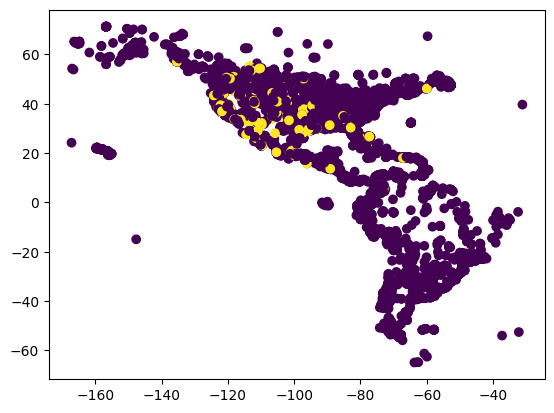

In [ ]:
plt.scatter(data[::100].longitude,data[::100].latitude,c=data[::100]['count'])

<AxesSubplot: xlabel='DOY'>

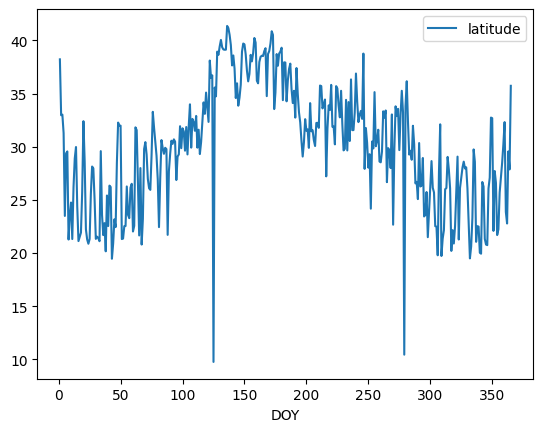

In [ ]:
data[['DOY','latitude']].groupby('DOY').median().plot()

In [8]:
##### get variable list
variable_dict = get_variable_dict()
variable_dict.keys()

dict_keys(['sampling_variables', 'time_variables', 'landscape_variables', 'climate_variables', 'land_use_variables'])

In [9]:
##### overall there are 105 predictors
all_variable_names = []
for i in variable_dict.values():
    all_variable_names.extend(i)
len(all_variable_names)


105

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


In [11]:
#### Because we will split data points into grids in the model, keep the longitude, latitude and 'sampling_event_identifier'! When training the model,
#### AdaSTEM will remove longitude, latitude and 'sampling_event_identifier'

In [12]:
all_variable_names

['duration_minutes',
 'Traveling',
 'Stationary',
 'Area',
 'obsvr_species_count',
 'DOY',
 'month',
 'week',
 'year',
 'time_observation_started_minute_of_day',
 'elevation_mean',
 'slope_mean',
 'eastness_mean',
 'northness_mean',
 'elevation_std',
 'slope_std',
 'eastness_std',
 'northness_std',
 'prec',
 'tmax',
 'tmin',
 'bio1',
 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'bio8',
 'bio9',
 'bio10',
 'bio11',
 'bio12',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio18',
 'bio19',
 'closed_shrublands',
 'closed_shrublands_ed',
 'closed_shrublands_lpi',
 'closed_shrublands_pd',
 'cropland_or_natural_vegetation_mosaics',
 'cropland_or_natural_vegetation_mosaics_ed',
 'cropland_or_natural_vegetation_mosaics_lpi',
 'cropland_or_natural_vegetation_mosaics_pd',
 'croplands',
 'croplands_ed',
 'croplands_lpi',
 'croplands_pd',
 'deciduous_broadleaf_forests',
 'deciduous_broadleaf_forests_ed',
 'deciduous_broadleaf_forests_lpi',
 'deciduous_broadleaf_forests_pd',
 'decidu

In [111]:
data.shape

(487293, 120)

In [18]:
eval_df = {
    'ensemble_fold':[],
    'grid_min':[],
    'grid_max':[],
    'training_size':[],
    'recall':[],
    'precision':[],
    'average_precision':[],
    'roc_auc':[],
    'cohen_kappa':[],
    'f1':[]
}

for fold in np.linspace(1,10,10):
    fold=int(fold)
    sub_sampled_data = data
    X = sub_sampled_data[all_variable_names+['longitude','latitude','sampling_event_identifier']]
    y = sub_sampled_data['count']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    for grid_min,grid_max in zip([2,4,8,16,24],[5,10,20,40,60]):
        
        base_model = RandomForestClassifier(oob_score=True,random_state=42)
        model = AdaSTEM(base_model = base_model,
                        ensemble_fold=fold,
                        grid_len_long_upper_threshold=grid_max,
                        grid_len_long_lower_threshold=grid_min,
                        grid_len_lat_upper_threshold=grid_max,
                        grid_len_lat_lower_threshold=grid_min,
                        points_lower_threshold=50
                        )
        model.fit(X_train,y_train)

        pred = model.predict_proba(X_test)
        y_test_m = y_test[~np.isnan(pred)]
        pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

        eval_df['ensemble_fold'].append(fold)
        eval_df['training_size'].append(len(X_train))
        eval_df['grid_min'].append(grid_min)
        eval_df['grid_max'].append(grid_max)
        
        eval_df['recall'].append(recall_score(y_test_m, pred_m))
        eval_df['precision'].append(precision_score(y_test_m, pred_m))
        eval_df['average_precision'].append(average_precision_score(y_test_m, pred_m))
        eval_df['roc_auc'].append(roc_auc_score(y_test_m, pred_m))
        eval_df['cohen_kappa'].append(cohen_kappa_score(y_test_m, pred_m))
        eval_df['f1'].append(f1_score(y_test_m, pred_m))



ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 5801/5801 [00:58<00:00, 98.55it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 2475/2475 [00:26<00:00, 93.99it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 958/958 [00:11<00:00, 87.09it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 373/373 [00:04<00:00, 74.91it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 146/146 [00:02<00:00, 60.82it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 6418/6418 [01:04<00:00, 99.66it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 2611/2611 [00:30<00:00, 84.63it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 968/968 [00:11<00:00, 81.00it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 347/347 [00:05<00:00, 66.41it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 167/167 [00:02<00:00, 63.91it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 6007/6007 [00:56<00:00, 107.15it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 2882/2882 [00:29<00:00, 97.80it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 927/927 [00:10<00:00, 87.38it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 340/340 [00:04<00:00, 78.59it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 166/166 [00:02<00:00, 60.94it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 6136/6136 [00:58<00:00, 105.37it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 2566/2566 [00:26<00:00, 95.81it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 925/925 [00:10<00:00, 90.08it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 405/405 [00:05<00:00, 79.99it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 142/142 [00:02<00:00, 60.77it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 6361/6361 [01:00<00:00, 105.85it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 2545/2545 [00:26<00:00, 96.45it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 953/953 [00:10<00:00, 89.36it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 373/373 [00:04<00:00, 80.16it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 164/164 [00:02<00:00, 62.79it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 6017/6017 [00:55<00:00, 108.57it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 2594/2594 [00:27<00:00, 95.67it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 1055/1055 [00:11<00:00, 89.88it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 334/334 [00:04<00:00, 78.42it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 153/153 [00:02<00:00, 61.58it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 6114/6114 [00:56<00:00, 108.56it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 2643/2643 [00:27<00:00, 94.80it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 1122/1122 [00:12<00:00, 89.69it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 349/349 [00:04<00:00, 78.27it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 147/147 [00:02<00:00, 62.47it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 6122/6122 [00:58<00:00, 104.47it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 2769/2769 [00:28<00:00, 96.97it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 1067/1067 [00:12<00:00, 87.86it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 401/401 [00:05<00:00, 78.92it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 146/146 [00:02<00:00, 61.53it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 5962/5962 [00:55<00:00, 106.61it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 2490/2490 [00:25<00:00, 98.86it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 1175/1175 [00:12<00:00, 91.74it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 378/378 [00:04<00:00, 81.49it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 164/164 [00:02<00:00, 62.52it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 6083/6083 [00:55<00:00, 110.05it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 2611/2611 [00:27<00:00, 96.13it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 929/929 [00:10<00:00, 89.10it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 347/347 [00:04<00:00, 76.65it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 151/151 [00:02<00:00, 60.83it/s]


In [13]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [19]:
eval_df = {
    'ensemble_fold':[],
    'grid_min':[],
    'grid_max':[],
    'training_size':[],
    'recall':[],
    'precision':[],
    'average_precision':[],
    'roc_auc':[],
    'cohen_kappa':[],
    'f1':[]
}

for frac in np.linspace(0.1,1,10):
    sub_sampled_data = data.sample(frac=frac,random_state=42)
    X = sub_sampled_data[all_variable_names+['longitude','latitude','sampling_event_identifier']]
    y = sub_sampled_data['count']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    for fold in range(1,11):
        base_model = RandomForestClassifier(oob_score=True,random_state=42)
        model = AdaSTEM(base_model = base_model,
                        ensemble_fold=fold,
                        grid_len_long_upper_threshold=25,
                        grid_len_long_lower_threshold=10,
                        grid_len_lat_upper_threshold=25,
                        grid_len_lat_lower_threshold=10,
                        points_lower_threshold=50
                        )
        model.fit(X_train,y_train)

        pred = model.predict_proba(X_test)
        y_test_m = y_test[~np.isnan(pred)]
        pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

        eval_df['ensemble_fold'].append(fold)
        eval_df['training_size'].append(len(X_train))
        eval_df['recall'].append(recall_score(y_test_m, pred_m))
        eval_df['precision'].append(precision_score(y_test_m, pred_m))
        eval_df['average_precision'].append(average_precision_score(y_test_m, pred_m))
        eval_df['roc_auc'].append(roc_auc_score(y_test_m, pred_m))
        eval_df['cohen_kappa'].append(cohen_kappa_score(y_test_m, pred_m))
        eval_df['f1'].append(f1_score(y_test_m, pred_m))



ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 369/369 [00:03<00:00, 102.02it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 366/366 [00:03<00:00, 107.55it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 380/380 [00:03<00:00, 104.85it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 356/356 [00:03<00:00, 98.51it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 381/381 [00:03<00:00, 109.19it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 416/416 [00:03<00:00, 108.71it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 495/495 [00:05<00:00, 95.88it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 479/479 [00:05<00:00, 93.85it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 420/420 [00:03<00:00, 106.18it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 400/400 [00:03<00:00, 107.94it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 536/536 [00:05<00:00, 99.94it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 531/531 [00:05<00:00, 103.84it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 428/428 [00:04<00:00, 103.78it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 458/458 [00:04<00:00, 105.83it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 391/391 [00:03<00:00, 103.45it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 402/402 [00:03<00:00, 105.14it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 371/371 [00:03<00:00, 105.47it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 382/382 [00:03<00:00, 103.90it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 421/421 [00:04<00:00, 103.97it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 542/542 [00:05<00:00, 102.78it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 632/632 [00:06<00:00, 98.77it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 581/581 [00:05<00:00, 98.33it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 477/477 [00:04<00:00, 100.22it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 385/385 [00:03<00:00, 99.75it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 422/422 [00:04<00:00, 99.91it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 436/436 [00:04<00:00, 101.73it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 391/391 [00:03<00:00, 100.88it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 394/394 [00:03<00:00, 100.63it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 398/398 [00:03<00:00, 102.10it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 382/382 [00:03<00:00, 96.03it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 511/511 [00:05<00:00, 96.60it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 612/612 [00:06<00:00, 99.44it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 579/579 [00:05<00:00, 98.07it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 441/441 [00:04<00:00, 95.51it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 627/627 [00:06<00:00, 99.94it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 634/634 [00:06<00:00, 101.58it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 447/447 [00:04<00:00, 96.91it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 460/460 [00:04<00:00, 98.82it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 407/407 [00:04<00:00, 96.31it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 438/438 [00:04<00:00, 97.17it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 391/391 [00:04<00:00, 92.40it/s] 


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 424/424 [00:04<00:00, 94.25it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 522/522 [00:05<00:00, 96.11it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 397/397 [00:04<00:00, 95.17it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 602/602 [00:06<00:00, 98.56it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 547/547 [00:05<00:00, 96.84it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 595/595 [00:06<00:00, 97.08it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 394/394 [00:04<00:00, 91.04it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 589/589 [00:06<00:00, 90.20it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 440/440 [00:04<00:00, 89.60it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 446/446 [00:05<00:00, 86.71it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 442/442 [00:05<00:00, 85.52it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 648/648 [00:07<00:00, 91.64it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 445/445 [00:05<00:00, 88.30it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 403/403 [00:04<00:00, 88.01it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 541/541 [00:06<00:00, 89.91it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 523/523 [00:05<00:00, 88.83it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 498/498 [00:05<00:00, 89.32it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 408/408 [00:04<00:00, 85.93it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 551/551 [00:06<00:00, 89.44it/s] 


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 565/565 [00:06<00:00, 85.26it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 544/544 [00:06<00:00, 85.96it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 446/446 [00:05<00:00, 86.35it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 645/645 [00:06<00:00, 93.10it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 402/402 [00:04<00:00, 87.94it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 627/627 [00:06<00:00, 91.07it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 405/405 [00:04<00:00, 86.03it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 439/439 [00:05<00:00, 81.38it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 443/443 [00:05<00:00, 77.40it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 626/626 [00:07<00:00, 79.78it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 581/581 [00:07<00:00, 76.40it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 648/648 [00:07<00:00, 88.77it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 415/415 [00:05<00:00, 79.46it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 546/546 [00:06<00:00, 88.63it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 570/570 [00:07<00:00, 79.84it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 554/554 [00:06<00:00, 85.64it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 636/636 [00:08<00:00, 74.87it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 410/410 [00:04<00:00, 87.19it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 547/547 [00:08<00:00, 66.72it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 534/534 [00:06<00:00, 86.22it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 449/449 [00:05<00:00, 81.64it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 607/607 [00:06<00:00, 87.05it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 442/442 [00:06<00:00, 70.94it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 598/598 [00:06<00:00, 87.52it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 577/577 [00:07<00:00, 81.86it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 459/459 [00:05<00:00, 83.58it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 452/452 [00:05<00:00, 75.71it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 635/635 [00:08<00:00, 72.68it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 603/603 [00:07<00:00, 79.07it/s] 


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 641/641 [00:07<00:00, 83.72it/s]


ensembel_count: 0


predicting ensemble 0 : 100%|██████████| 746/746 [00:09<00:00, 79.11it/s]


ensembel_count: 0
ensembel_count: 1


predicting ensemble 1 : 100%|██████████| 442/442 [00:05<00:00, 78.65it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2


predicting ensemble 2 : 100%|██████████| 451/451 [00:05<00:00, 80.20it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3


predicting ensemble 3 : 100%|██████████| 581/581 [00:07<00:00, 75.26it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4


predicting ensemble 4 : 100%|██████████| 585/585 [00:06<00:00, 85.25it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5


predicting ensemble 5 : 100%|██████████| 447/447 [00:05<00:00, 81.91it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6


predicting ensemble 6 : 100%|██████████| 670/670 [00:07<00:00, 85.39it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 610/610 [00:07<00:00, 84.26it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8


predicting ensemble 8 : 100%|██████████| 453/453 [00:05<00:00, 81.32it/s]


ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7
ensembel_count: 8
ensembel_count: 9


predicting ensemble 9 : 100%|██████████| 441/441 [00:05<00:00, 79.49it/s]


In [31]:
sum(np.isnan(pred))

8146

In [19]:
eval_df = pd.DataFrame(eval_df)

In [20]:
eval_df.to_csv('sensitivity_analysis_grid_ensemble.csv',index=False)

In [43]:
eval_df

,ensemble_fold,grid_min,grid_max,training_size,recall,precision,average_precision,roc_auc,cohen_kappa,f1
0,1,2,5,389834,0.891886,0.268990,0.246383,0.868745,0.353866,0.413323
1,1,4,10,389834,0.892596,0.260153,0.238652,0.865329,0.341752,0.402883
2,1,8,20,389834,0.898712,0.256548,0.236510,0.868126,0.338744,0.399154
3,1,16,40,389834,0.901463,0.253231,0.234032,0.868305,0.334739,0.395392
4,1,24,60,389834,0.896351,0.248996,0.229229,0.864518,0.328471,0.389730
5,2,2,5,389834,0.913282,0.262032,0.244371,0.876921,0.348089,0.407226
6,2,4,10,389834,0.916698,0.254230,0.237897,0.875317,0.337754,0.398064
7,2,8,20,389834,0.923193,0.251294,0.236414,0.877590,0.334859,0.395054
8,2,16,40,389834,0.927146,0.248386,0.234474,0.878116,0.331230,0.391806
9,2,24,60,389834,0.923193,0.249415,0.234667,0.877013,0.332394,0.392728


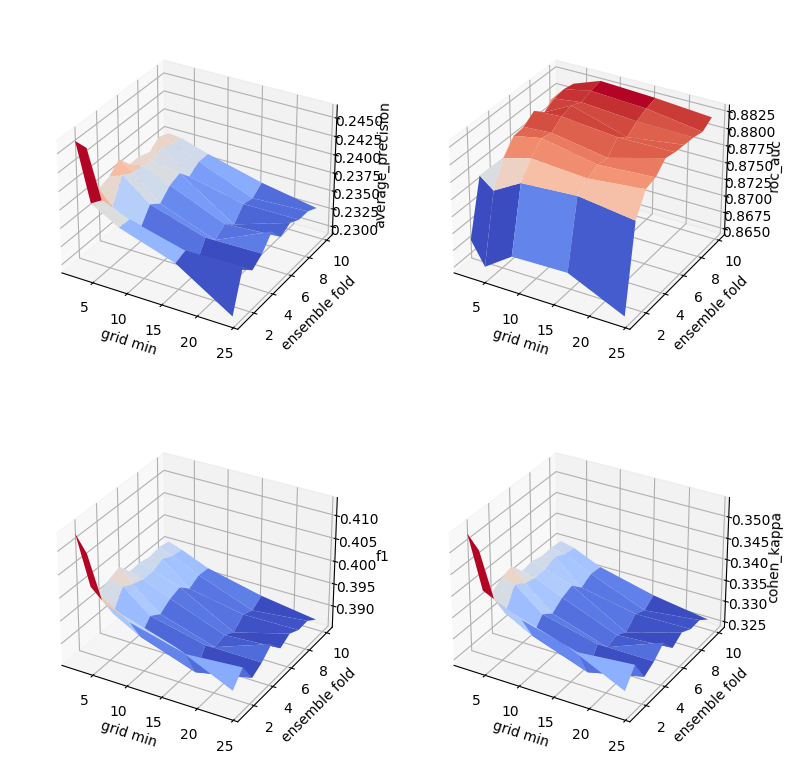

In [49]:
from matplotlib import cm
fig, ax = plt.subplots(2,2,subplot_kw=dict(projection='3d'),figsize=(8,8))

for a,b in zip([[0,0],[0,1],[1,1],[1,0]],
                    ['average_precision', 'roc_auc', 'cohen_kappa', 'f1']
                ):
    aa = ax[a[0],a[1]]
    aa.plot_surface(
         (eval_df.grid_min.values).reshape(10,5),
        eval_df.ensemble_fold.values.reshape(10,5),
       
        eval_df[b].values.reshape(10,5), cmap=cm.coolwarm
    )
    aa.set(
        xlabel='grid min',
        ylabel='ensemble fold',
        zlabel=f'{b}',
        # zticks=[0, -150, -300, -450],
    )
    aa.set_box_aspect(None, zoom=0.85)
    # 

# plt.title('Sensitivity analysis of data volume and ensemble fold')
plt.savefig('gird_parameters_tuning.png',dpi=500)
plt.tight_layout()


In [26]:
eval_df.ensemble_fold.values.reshape(10,5)

array([[ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10]])

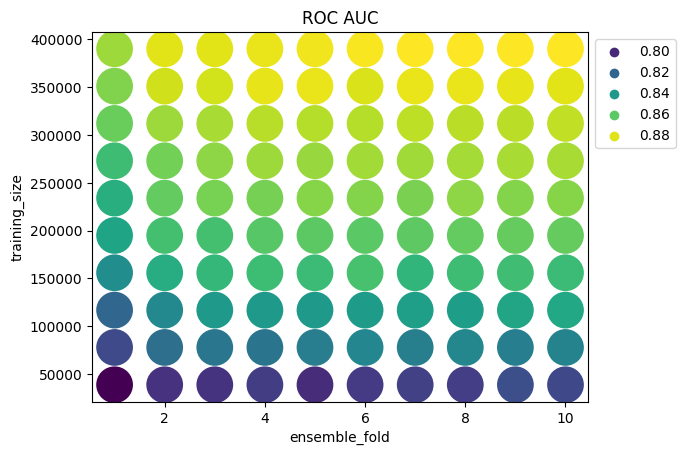

In [57]:
sns.scatterplot(x=eval_df.ensemble_fold,
                y=eval_df.training_size,
                hue=eval_df.roc_auc,
                s=600,palette='viridis',edgecolor=None)
plt.legend(bbox_to_anchor=(1,1))
plt.title('ROC AUC')
plt.show()


In [61]:
eval_df

,ensemble_fold,training_size,recall,precision,average_precision,roc_auc,cohen_kappa,f1
0,1,38983,0.826415,0.170163,0.150687,0.789223,0.205878,0.282216
1,2,38983,0.857708,0.167957,0.152024,0.802858,0.206617,0.280906
2,3,38983,0.870183,0.160976,0.147207,0.803329,0.197297,0.271691
3,4,38983,0.867347,0.164346,0.149804,0.806030,0.203007,0.276333
4,5,38983,0.857434,0.163305,0.147850,0.801129,0.200632,0.274356
...,...,...,...,...,...,...,...,...
95,6,389834,0.944347,0.243382,0.233010,0.883425,0.325905,0.387019
96,7,389834,0.944031,0.245671,0.235113,0.884356,0.329162,0.389881
97,8,389834,0.943640,0.246159,0.235499,0.884437,0.329840,0.390461
98,9,389834,0.945066,0.244704,0.234394,0.884348,0.327870,0.388750


In [62]:
eval_df.ensemble_fold.values.reshape(10,10)

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [94]:
eval_df.columns

Index(['ensemble_fold', 'training_size', 'recall', 'precision',
       'average_precision', 'roc_auc', 'cohen_kappa', 'f1'],
      dtype='object')

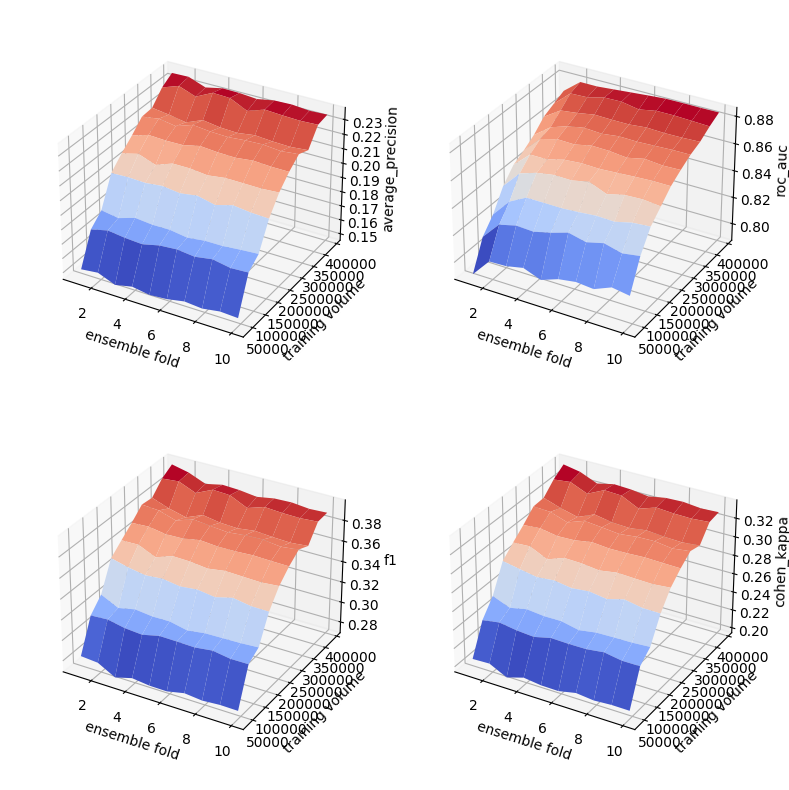

In [110]:
from matplotlib import cm
fig, ax = plt.subplots(2,2,subplot_kw=dict(projection='3d'),figsize=(8,8))

for a,b in zip([[0,0],[0,1],[1,1],[1,0]],
                    ['average_precision', 'roc_auc', 'cohen_kappa', 'f1']
                ):
    aa = ax[a[0],a[1]]
    aa.plot_surface(
        eval_df.ensemble_fold.values.reshape(10,10),
        eval_df.training_size.values.reshape(10,10),
        eval_df[b].values.reshape(10,10), cmap=cm.coolwarm
    )
    aa.set(
        xlabel='ensemble fold',
        ylabel='training volume',
        zlabel=f'{b}',
        # zticks=[0, -150, -300, -450],
    )
    aa.set_box_aspect(None, zoom=0.85)
    # 
plt.tight_layout()
# title('Sensitivity analysis of data volume and ensemble fold')


In [60]:
eval_df.ensemble_fold.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [59]:
X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ...,
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])

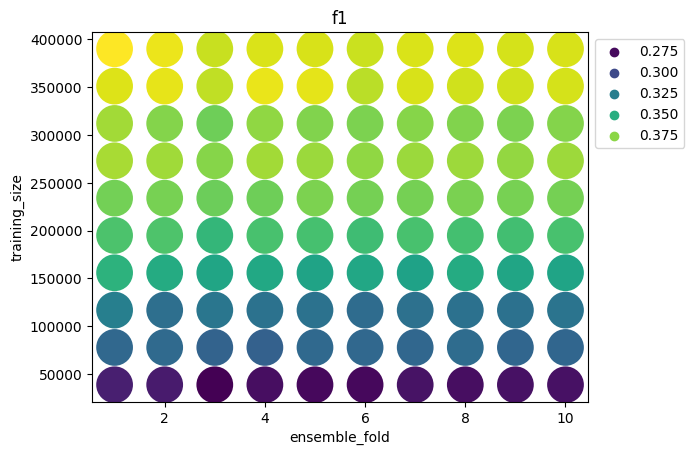

In [41]:
sns.scatterplot(x=eval_df.ensemble_fold,
                y=eval_df.training_size,
                hue=eval_df.f1,
                s=600,palette='viridis',edgecolor=None)
plt.legend(bbox_to_anchor=(1,1))
plt.title('f1')
plt.show()


In [13]:
eval_df = pd.DataFrame(eval_df)
eval_df.index=eval_df.index+1

In [84]:
eval_df

,ensemble_fold,training_size,recall,precision,average_precision,roc_auc,cohen_kappa,f1
0,1,38983,0.826415,0.170163,0.150687,0.789223,0.205878,0.282216
1,2,38983,0.857708,0.167957,0.152024,0.802858,0.206617,0.280906
2,3,38983,0.870183,0.160976,0.147207,0.803329,0.197297,0.271691
3,4,38983,0.867347,0.164346,0.149804,0.806030,0.203007,0.276333
4,5,38983,0.857434,0.163305,0.147850,0.801129,0.200632,0.274356
...,...,...,...,...,...,...,...,...
95,6,389834,0.944347,0.243382,0.233010,0.883425,0.325905,0.387019
96,7,389834,0.944031,0.245671,0.235113,0.884356,0.329162,0.389881
97,8,389834,0.943640,0.246159,0.235499,0.884437,0.329840,0.390461
98,9,389834,0.945066,0.244704,0.234394,0.884348,0.327870,0.388750


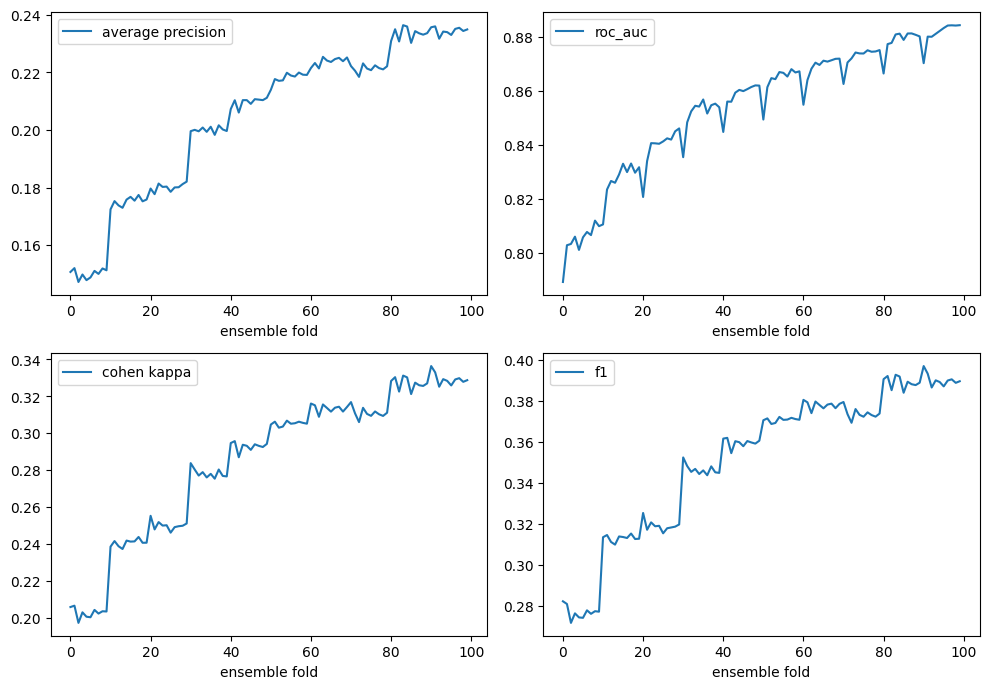

In [83]:
fig,ax=plt.subplots(2,2,figsize=(10,7))
plt.sca(ax[0,0])
eval_df.average_precision.plot(label='average precision')
plt.xlabel('ensemble fold')
plt.legend()

plt.sca(ax[0,1])
eval_df.roc_auc.plot(label='roc_auc')
plt.xlabel('ensemble fold')
plt.legend()

plt.sca(ax[1,0])
eval_df.cohen_kappa.plot(label='cohen kappa')
plt.xlabel('ensemble fold')
plt.legend()

plt.sca(ax[1,1])
eval_df.f1.plot(label='f1')
plt.xlabel('ensemble fold')
plt.legend()

plt.tight_layout()
plt.show()

 27%|██▋       | 61/223 [00:01<00:03, 41.95it/s]


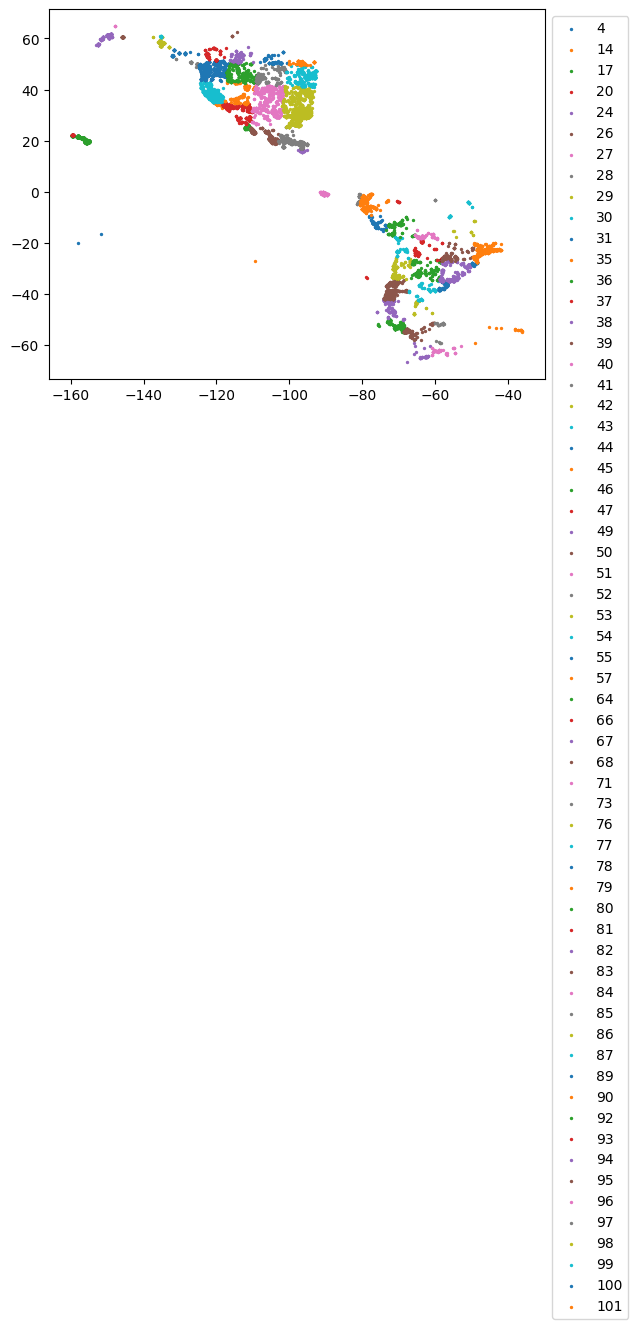

  8%|▊         | 63/771 [00:01<00:15, 45.17it/s]


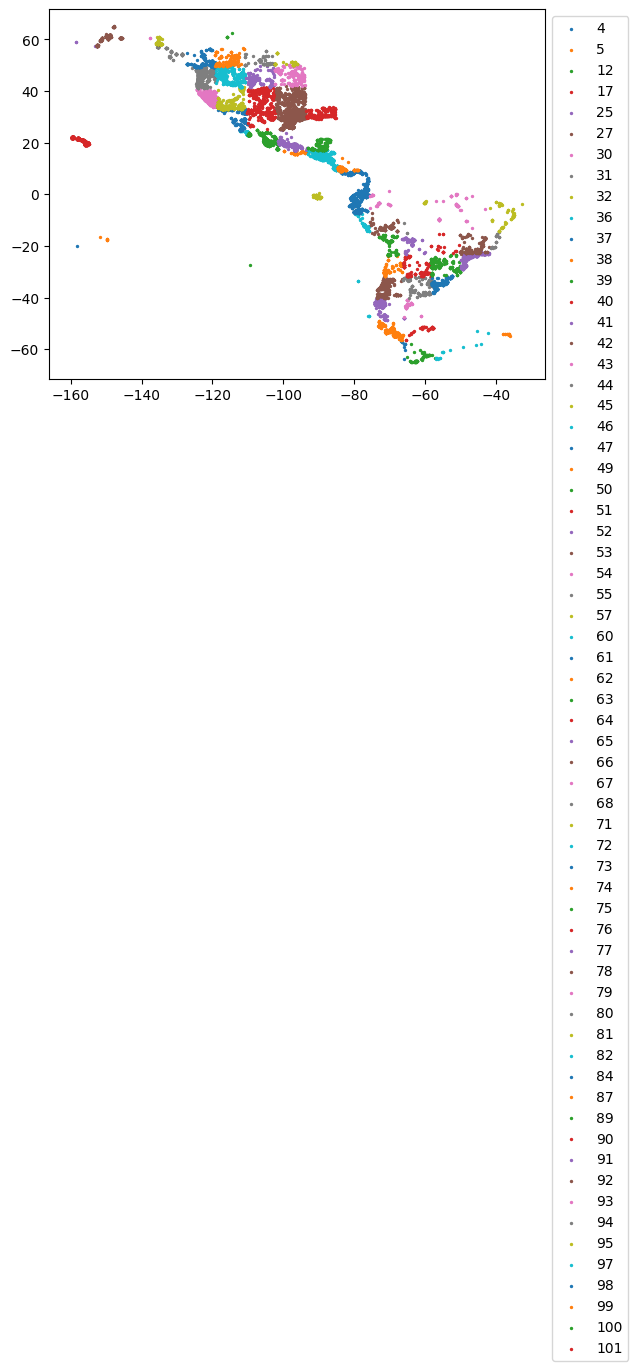

 18%|█▊        | 64/348 [00:01<00:06, 43.03it/s]


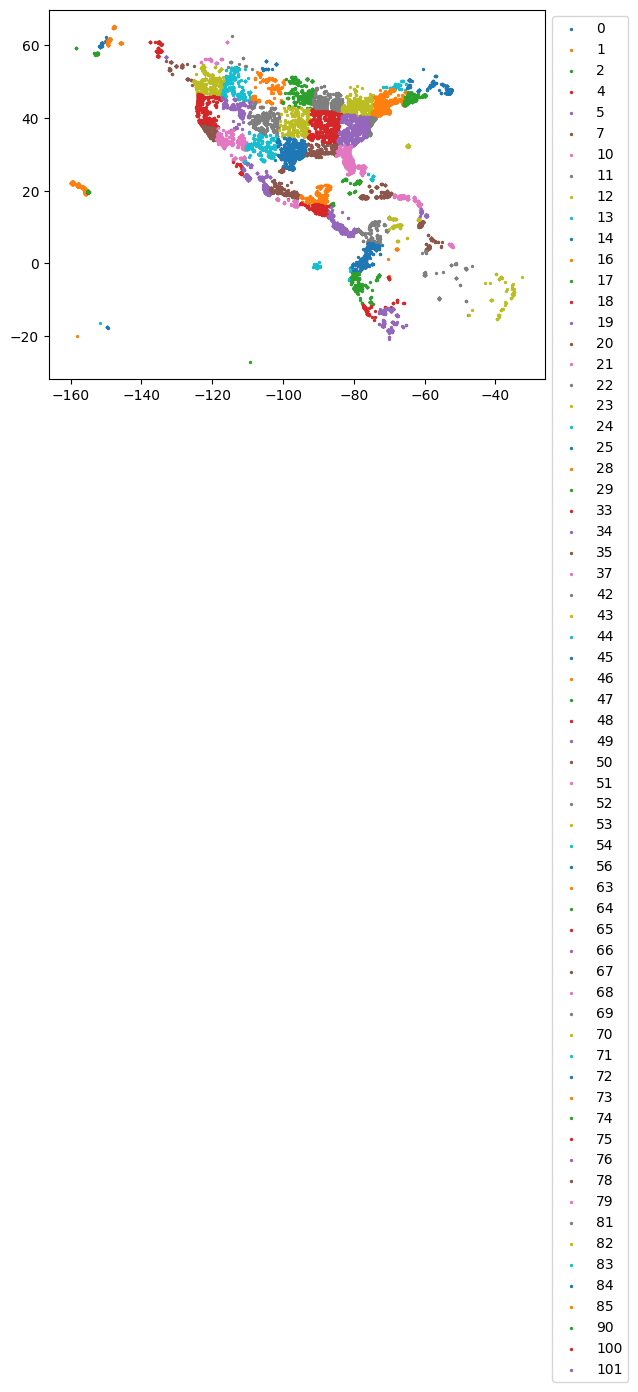

 15%|█▍        | 75/511 [00:02<00:12, 34.00it/s]


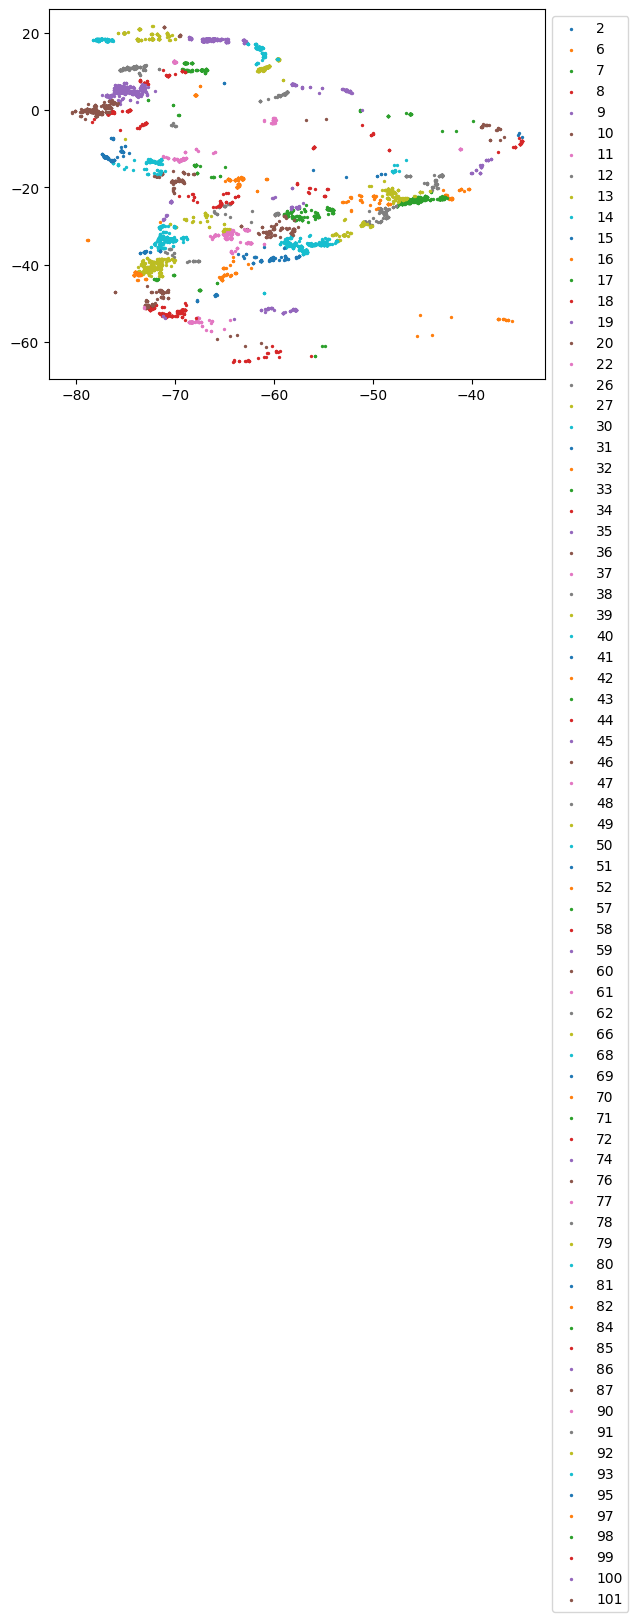

  5%|▌         | 32/611 [00:00<00:13, 43.39it/s]


KeyboardInterrupt: 

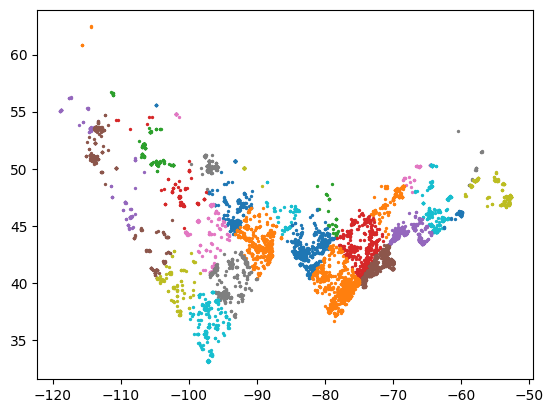

In [86]:
for en in model.ensemble_df.ensemble_index.unique():
    sub1 = model.ensemble_df[model.ensemble_df.ensemble_index==en]
    for index,i in tqdm(sub1.iterrows(),total=len(sub)):
        sub = X_train[X_train['sampling_event_identifier'].isin(i.checklist_name)]
        plt.scatter(sub.longitude,sub.latitude,label=index,s=2)
        if index>100:
            break
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


In [89]:
p_list = []
for m in sorted(data.month.unique()):
    p_list.append(data[data.month==m])

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize=(10,10),facecolor="grey")

def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    point = p_list[i]
    # Plot that point using the x and y coordinates
    ax.scatter(point.longitude, point.latitude, c=point['count'],
                    cmap='coolwarm',
                    s=5)
    # Set the x and y axis to display a fixed range
    ax.set_ylim([-60, 80])
    ax.set_xlim([-160, -50])
    ax.patch.set_facecolor('grey')
    mm = point.month.values[0]
    ax.set_title(f'American_Coot, month {mm}')
    
ani = FuncAnimation(fig, animate, frames=len(p_list),
                    interval=20, repeat=False)
plt.close()


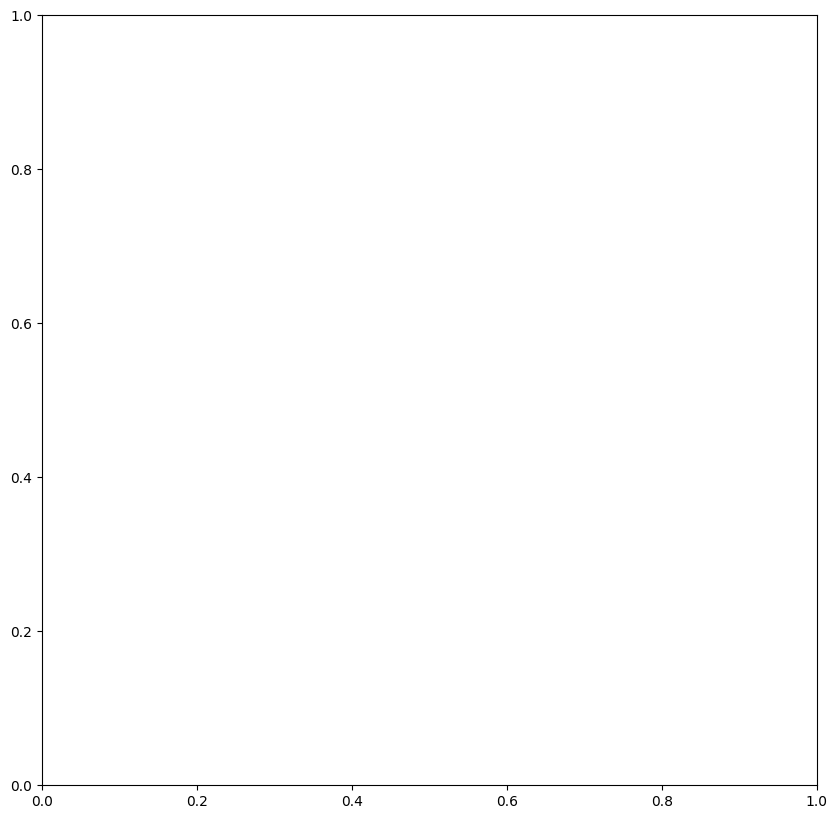

In [96]:
fig

In [114]:

from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("simple_animation.gif", dpi=300,
         writer=PillowWriter(fps=4))
         

In [35]:
import json
simple_model_metrics = json.loads(open('/Users/chenyangkang/Desktop/MADS/696/Project/classifier_results.json','r').read())


In [36]:
simple_model_metrics.keys()

dict_keys(['American_Crow', 'American_Robin', 'Turkey_Vulture', 'Mallard', 'Black-capped_Chickadee', 'House_Wren'])

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
eval_df = {
    'sp':[],
    # '':[],
    'recall':[],
    'precision':[],
    'average_precision':[],
    'roc_auc':[],
    'cohen_kappa':[],
    'f1':[]
}

model_dict = {}

for sp in ['American_Crow', 'American_Robin', 'Turkey_Vulture', 'Mallard', 'Black-capped_Chickadee', 'House_Wren']:
    print(sp)
    #### species count data
    sp_data = pickle.load(open(f'./sp_count/{sp}_2018.pkl','rb'))
    #### merge them
    data = pd.merge(checklist_feature, sp_data, on='sampling_event_identifier', how='left')
    data['count'] = data['count'].fillna(0)
    data['count'] = np.where(data['count']>0,1,0)

    X = data[all_variable_names+['longitude','latitude','sampling_event_identifier']]
    y = data['count']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    base_model = XGBClassifier(random_state=42,eval_metric='logloss')
    model = AdaSTEM(base_model = base_model,
                    ensemble_fold=8,
                    grid_len_long_upper_threshold=25,
                    grid_len_long_lower_threshold=10,
                    grid_len_lat_upper_threshold=25,
                    grid_len_lat_lower_threshold=10,
                    points_lower_threshold=50
                    )
    model.fit(X_train,y_train)

    pred = model.predict_proba(X_test)
    y_test_m = y_test[~np.isnan(pred)]
    pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

    eval_df['sp'].append(sp)
    eval_df['recall'].append(recall_score(y_test_m, pred_m))
    eval_df['precision'].append(precision_score(y_test_m, pred_m))
    eval_df['average_precision'].append(average_precision_score(y_test_m, pred_m))
    eval_df['roc_auc'].append(roc_auc_score(y_test_m, pred_m))
    eval_df['cohen_kappa'].append(cohen_kappa_score(y_test_m, pred_m))
    eval_df['f1'].append(f1_score(y_test_m, pred_m))

    model_dict[sp]=model
    break



American_Crow
ensembel_count: 0
ensembel_count: 1
ensembel_count: 2
ensembel_count: 3
ensembel_count: 4
ensembel_count: 5
ensembel_count: 6
ensembel_count: 7


predicting ensemble 7 : 100%|██████████| 433/433 [00:04<00:00, 89.88it/s] 


In [53]:
pd.DataFrame(eval_df).to_csv('6_sp_AdaSTEM_metrics.csv',index=False)

In [54]:
pd.DataFrame(eval_df)

,sp,recall,precision,average_precision,roc_auc,cohen_kappa,f1
0,American_Crow,0.971649,0.458161,0.450468,0.853827,0.494296,0.622700
1,American_Robin,0.968536,0.461905,0.453283,0.853761,0.497713,0.625502
2,Turkey_Vulture,0.733267,0.495723,0.411557,0.784665,0.479663,0.591538
3,Mallard,0.912737,0.420019,0.395527,0.854335,0.475116,0.575300
4,Black-capped_Chickadee,0.979189,0.487722,0.480388,0.909106,0.574192,0.651126
5,House_Wren,0.918250,0.369590,0.351110,0.827881,0.405327,0.527047


In [55]:
simple_model_metrics.keys()

dict_keys(['American_Crow', 'American_Robin', 'Turkey_Vulture', 'Mallard', 'Black-capped_Chickadee', 'House_Wren'])

In [56]:
plot_df = {
    'sp':[],
    'model':[],
    'metric':[],
    'mean':[],
    'std':[]
}

for sp in simple_model_metrics.keys():
    ##### simple model
    for model in simple_model_metrics[sp].keys():
        for metric in simple_model_metrics[sp][model]:
            plot_df['sp'].append(sp)
            plot_df['model'].append(model)
            plot_df['metric'].append(metric)
            plot_df['mean'].append(simple_model_metrics[sp][model]['roc_auc']['mean'])
            plot_df['std'].append(simple_model_metrics[sp][model]['roc_auc']['std'])

##### AdaSTEM
for index,i in pd.DataFrame(eval_df).iterrows():
    for metric in ['recall', 'precision', 'average_precision', 'roc_auc',
                    'cohen_kappa', 'f1']:
        plot_df['sp'].append(i['sp'])
        plot_df['model'].append('AdaSTEM')
        plot_df['metric'].append(metric)
        plot_df['mean'].append(i[metric])
        plot_df['std'].append(np.nan)




In [57]:
plot_df = pd.DataFrame(plot_df)


In [58]:
width = 0.1
step=0.2

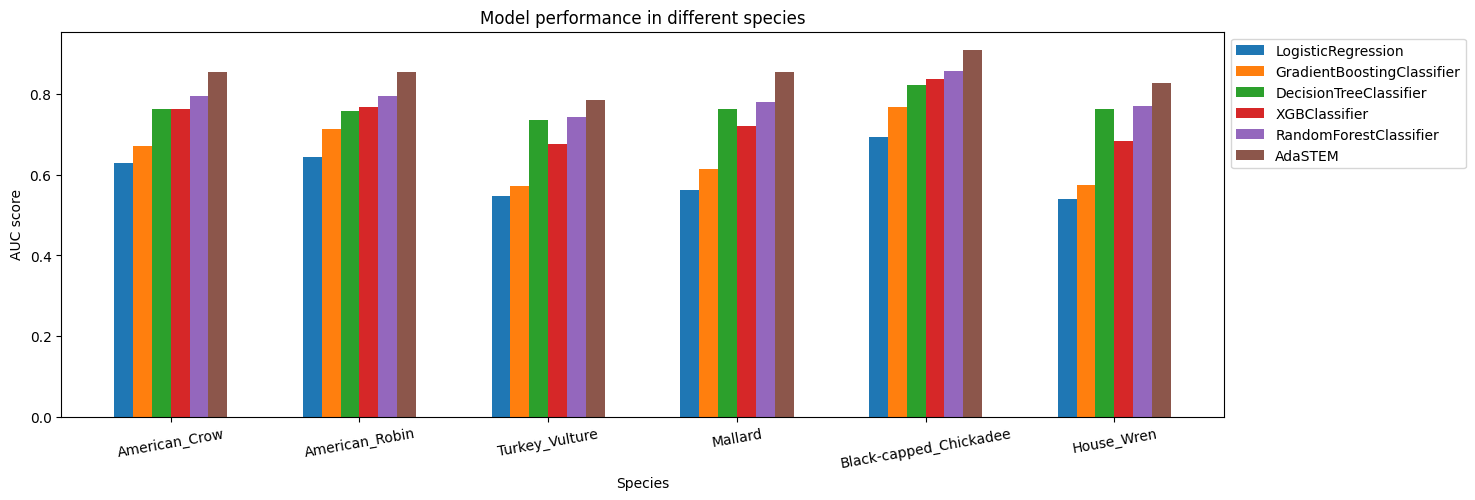

In [59]:
x = np.arange(len(plot_df.sp.unique()))

plt.figure(figsize=(15,5))
for count,model in enumerate(['LogisticRegression','GradientBoostingClassifier','DecisionTreeClassifier',
    'XGBClassifier','RandomForestClassifier','AdaSTEM']):
    sub = plot_df[plot_df.model==model]
    sub = sub[sub.metric=='roc_auc']
    plt.bar(x+count*width, sub['mean'], align='center',width=width,label = model) # ,yerr=sub['std']

plt.xticks(x + 2.5*width, plot_df.sp.unique(), rotation=10)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('AUC score')
plt.xlabel('Species')
plt.title('Model performance in different species')
plt.show()


In [49]:
mean_df = plot_df[plot_df.metric=='roc_auc'].pivot_table(index='sp',columns='model')['mean']
mean_df = round(mean_df,4)
std_df = plot_df[plot_df.metric=='roc_auc'].pivot_table(index='sp',columns='model')['std']
for index,i in std_df.iterrows():
    for model in i.index:
        mean_df.loc[index,model] = str(round(mean_df.loc[index,model],4)) + ' ('+str(round(std_df.loc[index,model],4))+')'
        

In [50]:
mean_df.reset_index(drop=False).to_csv('model_performance.csv',index=False)


In [51]:
mean_df


model,AdaSTEM,DecisionTreeClassifier,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier
sp,,,,,,
American_Crow,0.8538,0.7638 (0.0014),0.6718 (0.0013),0.63 (0.0024),0.794 (0.0019),0.7636 (0.002)
American_Robin,0.8538,0.7591 (0.001),0.7144 (0.0015),0.6429 (0.0017),0.7952 (0.001),0.7678 (0.002)
Black-capped_Chickadee,0.9091,0.8214 (0.0021),0.7667 (0.0021),0.6932 (0.0022),0.8576 (0.0012),0.8382 (0.0017)
House_Wren,0.8279,0.7635 (0.0016),0.574 (0.0015),0.5387 (0.0017),0.77 (0.0022),0.6823 (0.0015)
Mallard,0.8543,0.7618 (0.0025),0.614 (0.0021),0.5609 (0.0031),0.7798 (0.0021),0.72 (0.0017)
Turkey_Vulture,0.7847,0.7361 (0.0019),0.5723 (0.0024),0.5469 (0.001),0.7434 (0.0019),0.6754 (0.002)


In [221]:
index


'American_Crow'

In [13]:
model_dict = {

}

for sp in ['American_Crow', 'American_Robin', 'Turkey_Vulture', 'Mallard', 'Black-capped_Chickadee', 'House_Wren']:
    print(sp)
    #### species count data
    sp_data = pickle.load(open(f'./sp_count/{sp}_2018.pkl','rb'))
    #### merge them
    data = pd.merge(checklist_feature, sp_data, on='sampling_event_identifier', how='left')
    data['count'] = data['count'].fillna(0)
    data['count'] = np.where(data['count']>0,1,0)

    X = sub_sampled_data[all_variable_names+['longitude','latitude','sampling_event_identifier']]
    y = sub_sampled_data['count']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    base_model = XGBClassifier(random_state=42,eval_metric='logloss')
    model = AdaSTEM(base_model = base_model,
                    ensemble_fold=8,
                    grid_len_long_upper_threshold=25,
                    grid_len_long_lower_threshold=10,
                    grid_len_lat_upper_threshold=25,
                    grid_len_lat_lower_threshold=10,
                    points_lower_threshold=50
                    )
    model.fit(X_train,y_train)

    # pred = model.predict_proba(X_test)
    # y_test_m = y_test[~np.isnan(pred)]
    # pred_m = np.where(pred[~np.isnan(pred)]>0.05,1,0)

    break

    model_dict



American_Crow


NameError: name 'sub_sampled_data' is not defined